In [1]:
import numpy as np
import copy
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import preprocessing_modules as pm


In [2]:
enc=pm.ENCODE_data(cell_line='GM12878', assembly='hg19', res=100000 ,histones=False, total_rna=True, tf=False)

Selected cell line to predict: GM12878
Selected assembly: hg19
Selected signal type: signal p-value
Selected resolution:  100 kb


In [15]:
enc.download()

Number of replicas: 36


Process replicas: 100%|████████████████████████████████████████| 36/36 [02:49<00:00,  4.72s/it]


Experiments found in ENCODE for the selected cell line:
RNA-seq-minus-total
RNA-seq-plus-total
Downoaded data stored at:  ENCODE_data/GM12878_hg19_50k


In [24]:
df_x,labels=enc.get_training_data(n_neighbor=1)


print(df_x.sample(20), len(labels))

Loading data from: ENCODE_data/GM12878_hg19_100k
There are 1 tracks: ['RNA']
Number of chromosomes:22

Normalizing data...
done!
          RNA_0    RNA_R1    RNA_L1
21471  0.165301  0.212847  0.130709
1530   0.051791  0.062162  0.670632
2781   0.111294  0.930880  0.110275
15373  1.000000  0.083266  0.136577
22251  0.467346  1.000000  0.156336
10214  1.000000  0.486501  0.711888
11381  0.109964  0.074552  0.108490
6004   0.432699  0.140946  1.000000
7382   0.543755  1.000000  0.694131
22578  0.338160  0.074855  0.439223
23690  0.341249  0.152949  0.730458
26794  1.000000  0.873883  0.320212
5482   0.131470  0.061070  0.086633
7699   0.142330  0.180993  0.135947
3239   1.000000  1.000000  0.973783
11348  0.442833  0.090688  0.124953
18046  0.723895  0.542897  0.302477
1542   1.000000  1.000000  1.000000
19752  0.058142  0.068117  0.041706
2787   0.399008  0.088076  0.554151 26226


In [4]:
sum(enc.get_chrm_size())

30376

In [4]:
np.unique(labels)

array([0., 1.])

In [4]:
df.sample(10)

,RNA_0,RNA_R1,RNA_L1,RNA_R2,RNA_L2,labels
14302,0.114322,0.205089,0.122284,0.204626,0.253821,None
37119,0.060037,0.039596,0.084529,0.058316,0.011399,None
51972,0.018984,0.037174,0.015544,0.03192,0.011544,None
19515,0.347008,0.254549,0.215219,0.201838,0.442038,None
52105,0.919212,0.836655,1.0,0.362088,0.49183,None
22407,0.800614,1.0,1.0,0.526874,0.712088,None
42583,0.678164,1.0,0.534944,1.0,0.484826,None
46592,0.077914,0.092402,0.098474,0.244233,0.054517,None
8587,0.092136,0.078098,0.081935,0.24515,0.084996,None
43490,0.051674,0.0,0.057645,0.0,0.002545,None


In [37]:
features_all = df.columns.to_numpy()[:-1]
# print(features_all)

data = df.to_numpy()
x_pre, y_pre = data[:,:-1], data[:,-1]


print(x_pre.shape, y_pre.shape, features_all.shape)

(52452, 760) (52452,) (760,)


In [28]:
print(df[features_all[198]].to_numpy())

print(x_pre[:, 198])

[0.53900784 0.9540162  0.3047727  ... 0.78025514 0.7082865  0.7330572 ]
[0.53900784 0.9540162  0.3047727  ... 0.78025514 0.7082865  0.7330572 ]


In [26]:
X_train, X_test, Y_train, Y_test = train_test_split(df_x.to_numpy(), labels, test_size=0.25, random_state=1223)

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(19669, 3) (19669,) (6557, 3) (6557,)


In [27]:
learning_rate = 0.002
dropout_rate = 0.2
num_epochs = 30
batch_size = 64
num_features=df_x.shape[1]
num_classes=2

In [7]:
def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history


In [8]:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["accuracy"])
    ax2.plot(history.history["val_accuracy"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()


In [9]:
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)


In [20]:
def create_baseline_model(num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    
    x = create_ffn([32,32], dropout_rate, name=f"ffn_block1")(inputs)
    # x = create_ffn([64], dropout_rate, name=f"ffn_block2")(x)
    for block_ndx in range(2):
        x1 = create_ffn([32,32], dropout_rate, name=f"ffn_block{block_ndx+3}")(x)
        x = layers.Add(name=f"skip_connection{block_ndx+1}")([x, x1])

    x = create_ffn([16], dropout_rate, name=f"ffn_block{block_ndx+4}")(x)
    
    # Compute logits.
    logits = layers.Dense(num_classes, name="logits")(x)
    # Create the model.
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")


In [28]:
baseline_model = create_baseline_model(num_classes, dropout_rate)

baseline_model.summary()

Model: "baseline"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_features (InputLayer)    [(None, 3)]          0           []                               
                                                                                                  
 ffn_block1 (Sequential)        (None, 32)           1324        ['input_features[0][0]']         
                                                                                                  
 ffn_block3 (Sequential)        (None, 32)           2368        ['ffn_block1[0][0]']             
                                                                                                  
 skip_connection1 (Add)         (None, 32)           0           ['ffn_block1[0][0]',             
                                                                  'ffn_block3[0][0]']      

In [11]:
# inputs = layers.Input(shape=(num_features,), name="input_features")
# test=create_ffn(hidden_units,dropout_rate, name=f"ffn_block1")#(inputs)

# y=test(X_train)

In [12]:
keras.utils.plot_model(baseline_model, to_file='model.png', show_shapes=True, dpi=150, show_layer_names=True, show_layer_activations=True, rankdir='TB')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [29]:
history = run_experiment(baseline_model, X_train, Y_train)


Epoch 1/30


2022-11-02 03:26:13.763290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


262/262 [==============================] - ETA: 0s - loss: 0.4213 - accuracy: 0.8143

2022-11-02 03:26:23.115356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


262/262 [==============================] - 11s 30ms/step - loss: 0.4213 - accuracy: 0.8143 - val_loss: 0.4854 - val_accuracy: 0.7987
Epoch 2/30
262/262 [==============================] - 7s 25ms/step - loss: 0.3872 - accuracy: 0.8304 - val_loss: 0.3990 - val_accuracy: 0.8363
Epoch 3/30
262/262 [==============================] - 7s 25ms/step - loss: 0.3865 - accuracy: 0.8330 - val_loss: 0.3618 - val_accuracy: 0.8482
Epoch 4/30
262/262 [==============================] - 6s 25ms/step - loss: 0.3786 - accuracy: 0.8339 - val_loss: 0.3589 - val_accuracy: 0.8445
Epoch 5/30
262/262 [==============================] - 6s 25ms/step - loss: 0.3770 - accuracy: 0.8353 - val_loss: 0.3781 - val_accuracy: 0.8394
Epoch 6/30
262/262 [==============================] - 6s 25ms/step - loss: 0.3761 - accuracy: 0.8355 - val_loss: 0.3737 - val_accuracy: 0.8509
Epoch 7/30
262/262 [==============================] - 6s 24ms/step - loss: 0.3729 - accuracy: 0.8366 - val_loss: 0.3603 - val_accuracy: 0.8465
Epoch 8/3

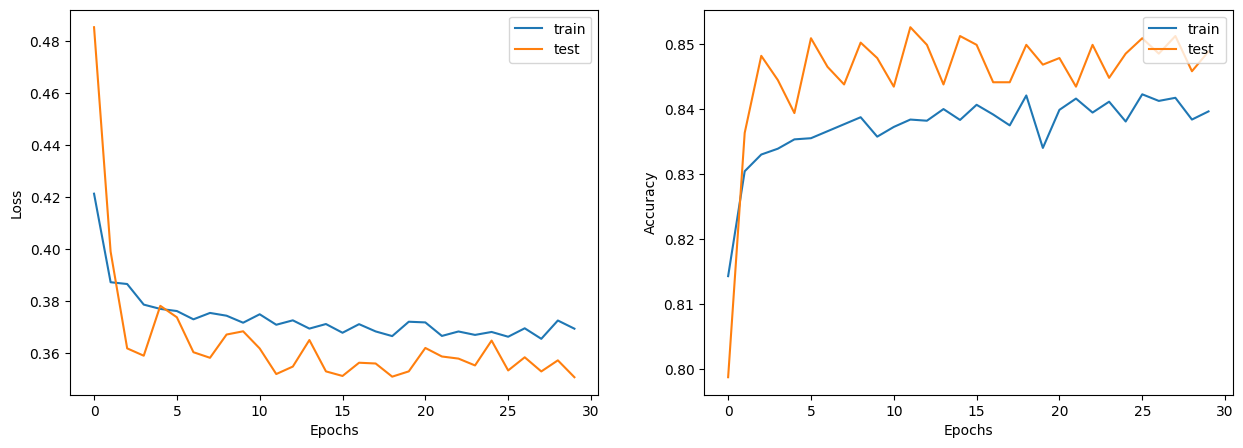

In [30]:
display_learning_curves(history)

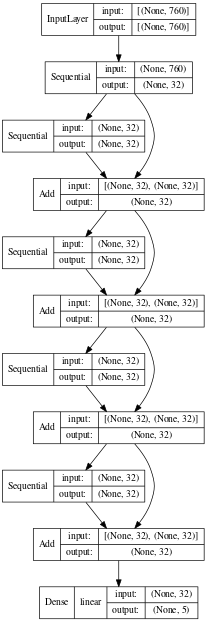

In [16]:
inputs = keras.Input(shape=X_train.shape[1])

# x1 = layers.Dense(32, activation="relu")(inputs)
x = layers.Dense(64, activation="relu")(inputs)
x = layers.Dense(128, activation="relu",bias_regularizer=tf.keras.regularizers.L2(0.001))(x)
# x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(64, activation="relu", bias_regularizer=tf.keras.regularizers.L2(0.001))(x)
# x = layers.add([x,x1])
# x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(len(np.unique(Y_train)), activation='relu')(x)

# del model
model = keras.Model(name="Predict-Chromatin-Types", inputs=inputs, outputs=outputs)

model.summary()

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(5e-4),
    metrics=["accuracy"],
)

Model: "Predict-Chromatin-Types"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense_8 (Dense)             (None, 64)                384       
                                                                 
 dense_9 (Dense)             (None, 128)               8320      
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 5)                 325       
                                                                 
Total params: 17,285
Trainable params: 17,2

In [17]:
history = model.fit(X_train, Y_train, batch_size=64, epochs=60, validation_split=0.2)

Epoch 1/60
  1/246 [..............................] - ETA: 1:13 - loss: 0.8607 - accuracy: 0.1719

2022-11-02 03:06:05.454435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


246/246 [==============================] - ETA: 0s - loss: 0.4521 - accuracy: 0.2102

2022-11-02 03:06:08.126990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


246/246 [==============================] - 3s 12ms/step - loss: 0.4521 - accuracy: 0.2102 - val_loss: 0.3746 - val_accuracy: 0.2214
Epoch 2/60
246/246 [==============================] - 3s 11ms/step - loss: 0.3903 - accuracy: 0.2155 - val_loss: 0.3842 - val_accuracy: 0.2201
Epoch 3/60
246/246 [==============================] - 3s 11ms/step - loss: 0.3853 - accuracy: 0.2151 - val_loss: 0.3798 - val_accuracy: 0.2171
Epoch 4/60
246/246 [==============================] - 3s 11ms/step - loss: 0.3801 - accuracy: 0.2201 - val_loss: 0.3680 - val_accuracy: 0.2199
Epoch 5/60
246/246 [==============================] - 3s 11ms/step - loss: 0.3789 - accuracy: 0.2151 - val_loss: 0.3613 - val_accuracy: 0.2239
Epoch 6/60
246/246 [==============================] - 3s 11ms/step - loss: 0.3725 - accuracy: 0.2199 - val_loss: 0.3697 - val_accuracy: 0.2194
Epoch 7/60
246/246 [==============================] - 3s 11ms/step - loss: 0.3745 - accuracy: 0.2158 - val_loss: 0.3816 - val_accuracy: 0.2145
Epoch 8/60

KeyboardInterrupt: 

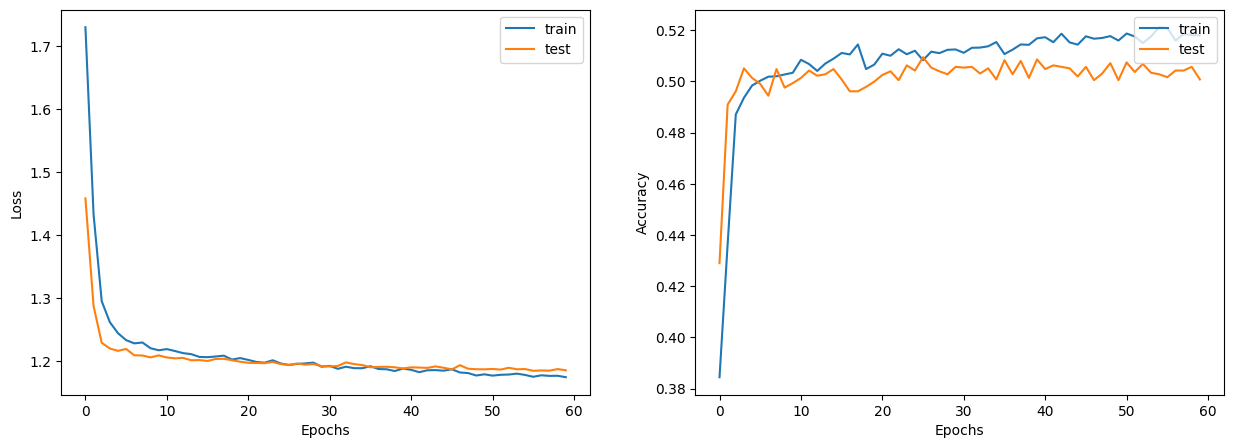

In [20]:
display_learning_curves(history)

In [ ]:
print(Y_test.shape, X_test.shape)
type_test={}

for val in np.unique(Y_test):
    ind = np.where(Y_test==val)[0]
    X_type=X_test[ind,:]
    Y_type=Y_test[ind]
    name=list(map(data.int_to_type.get, [val]))[0]

    print(name, Y_type.shape, X_type.shape)
    type_test[name] = (X_type,Y_type)

print(type_test.keys())


for key in type_test.keys():
    print("Type: ", key)
    test_scores = model.evaluate(type_test[key][0], type_test[key][1], verbose=2)
    print("Test loss:", test_scores[0])
    print("Test accuracy:", test_scores[1])